In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision.models as models
import glob
from PIL import Image
import torch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import random
import matplotlib
import matplotlib.pyplot as plt

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [2]:
NAME = "tSNE"

INPUT_DIR = "./input" # "../input"
WORKING_DIR = "./kaggle/working/" # "/kaggle/working/"

DATA_ROOT = os.path.join(WORKING_DIR, 'plates')
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
TEST_DIR = 'test'

In [3]:
# константы для ImageNet
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

## Итераторы

In [4]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms, models

from sklearn.model_selection import train_test_split

CLASS_NAMES = ['cleaned', 'dirty']

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=90, fill=255),
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(hue=(0.1, 0.2)), # brightness, contrast, saturation and hue
    # transforms.RandomInvert(0.3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms)

In [5]:
train_idx = np.arange(len(train_dataset))
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)     # random w/o replacement

TRAIN_SIZE = len(train_sampler)
BATCH_SIZE = TRAIN_SIZE # (// 2) if resnet152

def get_dataloader(dataset, sampler=None, batch_size=BATCH_SIZE):
    return torch.utils.data.DataLoader(dataset, 
                                       sampler=sampler,
                                       batch_size=batch_size,
                                       num_workers=4)

train_dataloader = get_dataloader(train_dataset, sampler=train_sampler)

In [6]:
import re 

class ImageFolderLOL(torchvision.datasets.ImageFolder):
    """ Мегахак:
    Атрибут original = True:
    - похож на оригинальный ImageFolder, только таргеты можно менять, изменяя атрибут targets
    Атрибут original = False:
    - возвращает образец и id картинки (считаем, что он соответствует индексу в датасете)
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.targets = torch.tensor(self.targets)
        self.original = True    

    def __getitem__(self, index):
        if self.original:
            original_tuple = super().__getitem__(index)             
            return (original_tuple[0], self.targets[index])         # (src, trg)
        else:
            original_tuple = super().__getitem__(index)
            path = self.imgs[index][0]
            image_id = re.search(r"([0-9]{4}).jpg$", path)[1]
            return (original_tuple[0], image_id)                    # (src, image_id)

test_dataset = ImageFolderLOL(TEST_DIR, test_transforms)

test_idx = np.arange(len(test_dataset))
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

test_dataloader = get_dataloader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Получение эмбеддингов

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
# model = models.googlenet(pretrained=True).to(device)
# model = models.resnet50(pretrained=True).to(device)
model = models.resnet101(pretrained=True).to(device)

**test**

In [17]:
model.eval()

embeddings = None
image_ids = None

test_dataset.original = False
for inputs, image_ids_ in test_dataloader:
    inputs = inputs.to(device)
    with torch.no_grad():
        embeddings_ = model.forward(inputs)
    
    embeddings = embeddings_ if (embeddings is None) else torch.cat((embeddings, embeddings_), 0)
    image_ids = image_ids_ if (image_ids is None) else image_ids + image_ids_

test_embeddings = np.array(embeddings.detach().cpu().numpy()).squeeze()
test_embeddings_cls = [-1] * len(test_dataset)

**train**

In [18]:
for inputs, labels in train_dataloader:  # 1 batch
    inputs = inputs.to(device)
    with torch.no_grad():
        embeddings_ = model.forward(inputs)

train_embeddings = np.array(embeddings_.detach().cpu().numpy()).squeeze()
train_embeddings_cls = labels

In [19]:
embeddings = np.vstack((test_embeddings, train_embeddings))
embeddings_cls = test_embeddings_cls + train_embeddings_cls.tolist()

# Кластеризация

In [20]:
embeddings2d = TSNE(n_components=2, 
                    random_state=3, 
                    perplexity=500, 
                    learning_rate='auto', 
                    init='pca',
                    ).fit_transform(embeddings)

/home/user1/envs/py310/lib64/python3/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


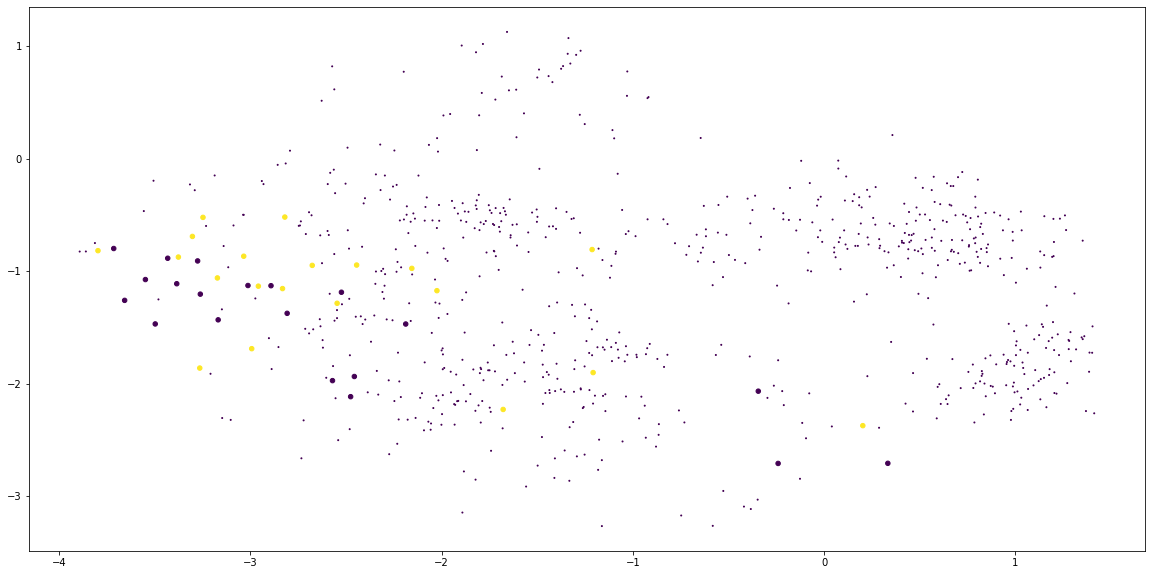

In [36]:
plt.figure(figsize=(20, 10))
x = embeddings2d[:,0]
y = embeddings2d[:,1]

plt.scatter(x[:-TRAIN_SIZE], y[:-TRAIN_SIZE], s=1, c=embeddings_cls[:-TRAIN_SIZE])
plt.scatter(x[-TRAIN_SIZE:], y[-TRAIN_SIZE:], s=20, c=embeddings_cls[-TRAIN_SIZE:])

# for i, txt in enumerate(image_ids):
#     plt.annotate(txt, (x[i], y[i]))

- чистый/грязный не кластеризуется

In [22]:
embeddings2d_pca = PCA(n_components=2, 
                    random_state=3
                    ).fit_transform(embeddings)

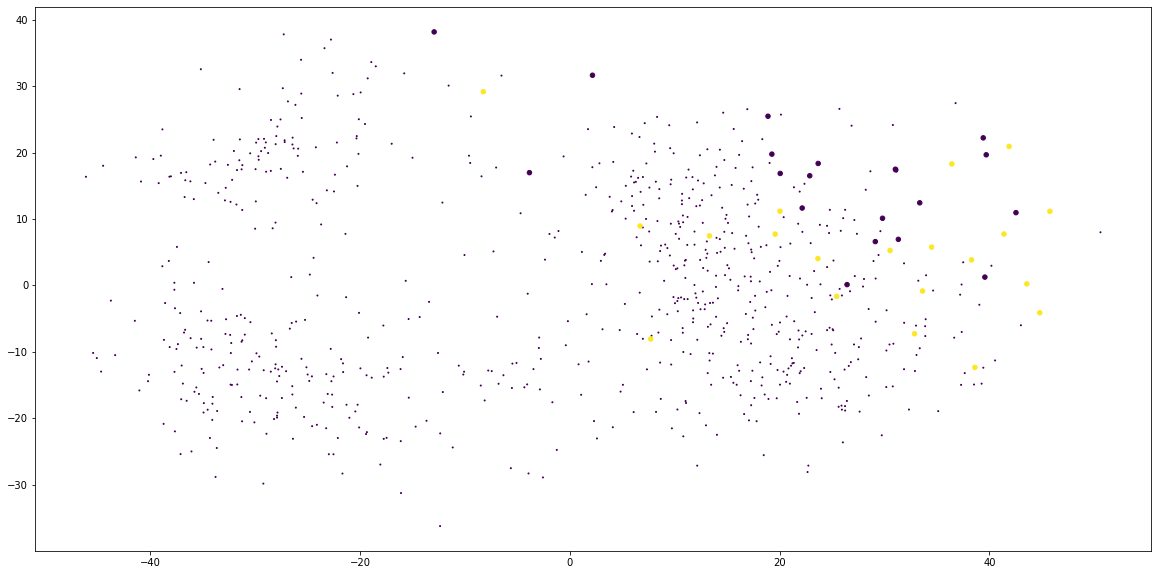

In [37]:
plt.figure(figsize=(20, 10))
x = embeddings2d_pca[:,0]
y = embeddings2d_pca[:,1]

plt.scatter(x[:-TRAIN_SIZE], y[:-TRAIN_SIZE], s=1, c=embeddings_cls[:-TRAIN_SIZE])
plt.scatter(x[-TRAIN_SIZE:], y[-TRAIN_SIZE:], s=20, c=embeddings_cls[-TRAIN_SIZE:])

# for i, txt in enumerate(image_ids):
#     plt.annotate(txt, (x[i], y[i]))

- аналогично